# SIR

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.sir import SIR
from loss_cal.costs import RevGaussCost
from loss_cal.actions import Action
from loss_cal.utils.utils import load_data
from loss_cal.predictor import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"

In [3]:
import sbi
sbi.__version__

'0.21.0'

## Set Up

In [4]:
sir = SIR(action_type="continuous")
task_name = sir.task_name
task_name

'sir'

Prior and Simulator

In [5]:
prior = sir.get_prior()
simulator = sir.get_simulator()

In [6]:
print(sir.dim_data,              # dimensionality data, here: 10
      sir.dim_parameters,        # dimensionality parameters, here: 2
      sir.num_observations)      # number of different observations x_o available, here: 10

10 2 10


10 observations provided by the sbibm task

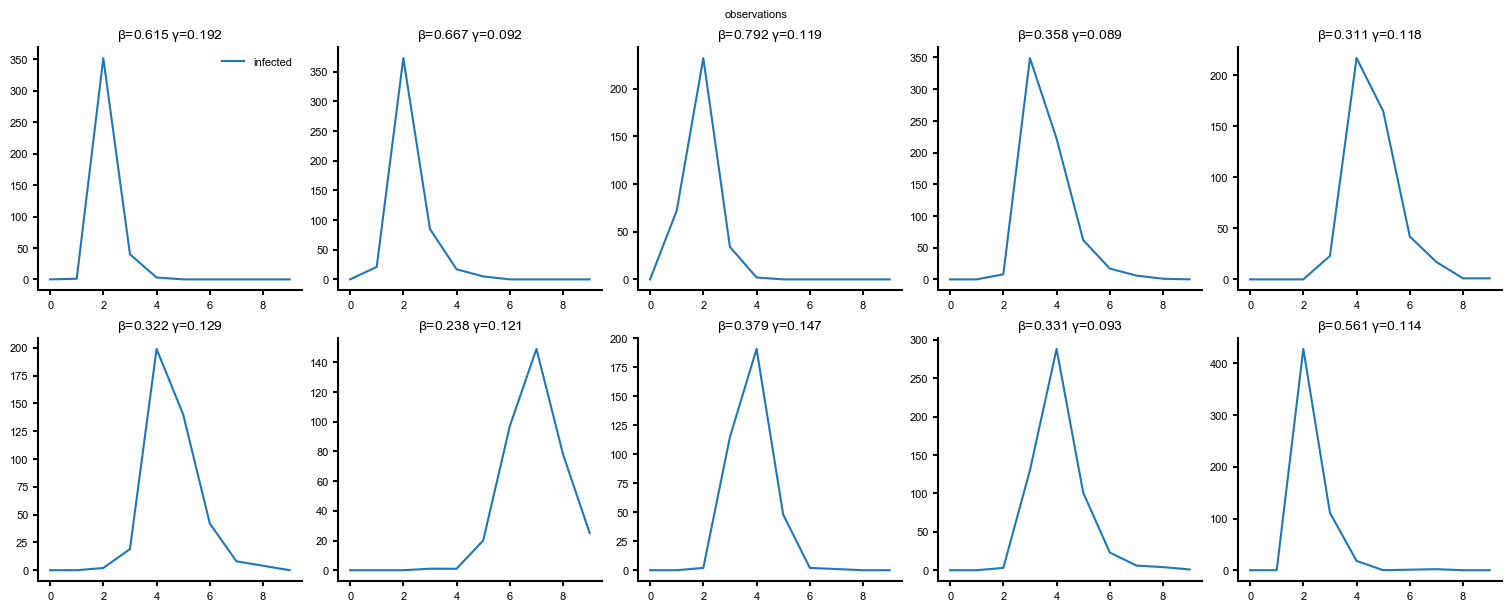

In [14]:
with mpl.rc_context(fname=plot_config_file):
    fig, axes = sir.plot_observations(2,5)
    plt.show()  

Prior

In [8]:
sir.prior_params

{'loc': tensor([-0.9163, -2.0794]), 'scale': tensor([0.5000, 0.2000])}

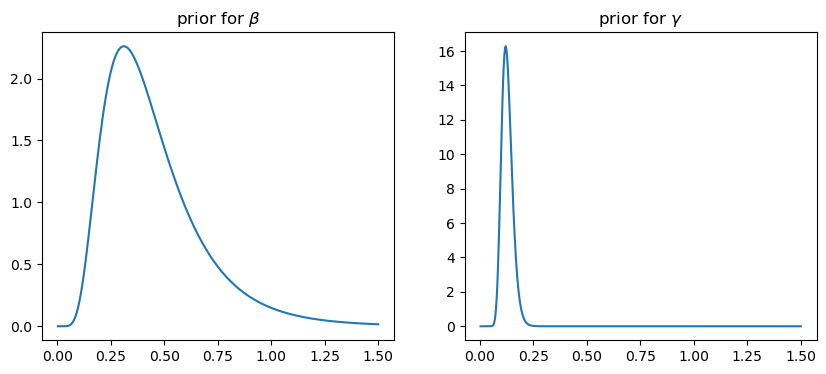

In [9]:
# priors defined as Log Normal with 
mu_p1 = -0.9163
mu_p2 =  -2.0794
sigma_p1 = 0.5
sigma_p2 = 0.2

ths  = torch.linspace(0,1.5, 500)
log_normal1 = torch.distributions.LogNormal(mu_p1, sigma_p1)
log_normal2 = torch.distributions.LogNormal(mu_p2, sigma_p2)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths, torch.exp(log_normal1.log_prob(ths)))
axes[0].set_title(r'prior for $\beta$')
axes[1].plot(ths, torch.exp(log_normal2.log_prob(ths)))
axes[1].set_title(r'prior for $\gamma$')
plt.show()

Posterior

Only 10 reference samples given

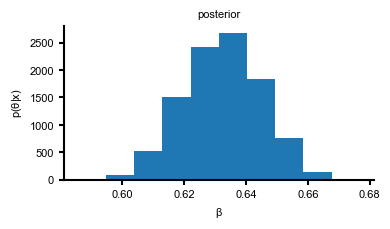

In [10]:
param = 0
n_obs = 1
posterior_evals = sir.get_reference_samples(n_obs)[:, param]
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    ax.hist(posterior_evals)
    ax.set_xlabel(rf"{sir.parameter_names[param]}")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Continuous Actions

### Decision Task

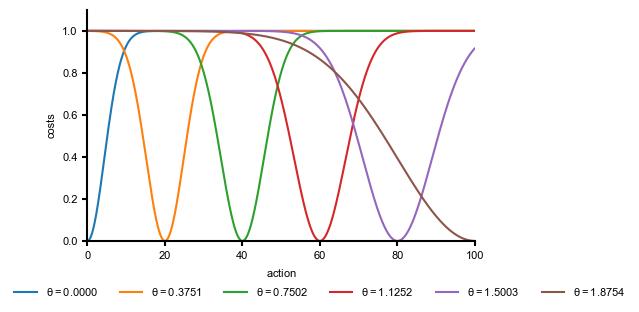

In [11]:
factor = 2
exponential = 0.5
param = 0
parameter_range = (sir.param_high - sir.param_low)[param].item()
cost_fn = RevGaussCost(
    parameter_range=parameter_range, ## FIXED PARAMETER
    action_range=sir.action_high - sir.action_low,
    factor=factor,
    exponential=exponential,
    aligned=False
)

with mpl.rc_context(fname=plot_config_file):
    resolution = 1000
    actions = torch.arange(sir.action_low, sir.action_high, (sir.action_high - sir.action_low) / resolution)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for theta in torch.arange(sir.param_low[param].item(), sir.param_high[param].item() + 0.01, parameter_range/5):
        ax.plot(actions, cost_fn(theta, actions), label=rf"$\theta={theta:.4f}$")

    ax.set_xlabel(r"$action$")
    ax.set_ylabel("costs")
    ax.set_xlim(sir.action_low, sir.action_high)
    ax.set_ylim(0, 1.1)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.6, -0.15),
        fancybox=True,
        shadow=True,
        ncol=6,
    )
    # plt.savefig("./results/continuous/toy_example/fig_cost_fct.pdf")
    plt.show()

In [12]:
print("Fix parameter range to range of quotients (based on values n theta_train and params_reference)")
param=None
cost_fn = RevGaussCost(
    parameter_range=4.-0.,
    action_range=sir.action_high - sir.action_low,
    factor=factor,
    exponential=exponential,
    aligned=False,
    offset=1
)

x_reference = torch.vstack([sir.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([sir.get_reference_samples(i) for i in range(1,11)])#[:,:,param]
param_reference = torch.vstack([sir.get_true_parameters(i) for i in range(1,11)])#[:,param]
param_reference[:,0]/param_reference[:,1]

Fix parameter range to range of quotients (based on values n theta_train and params_reference)


tensor([3.2067, 7.2351, 6.6723, 4.0198, 2.6283, 2.4998, 1.9634, 2.5876, 3.5573,
        4.9114])

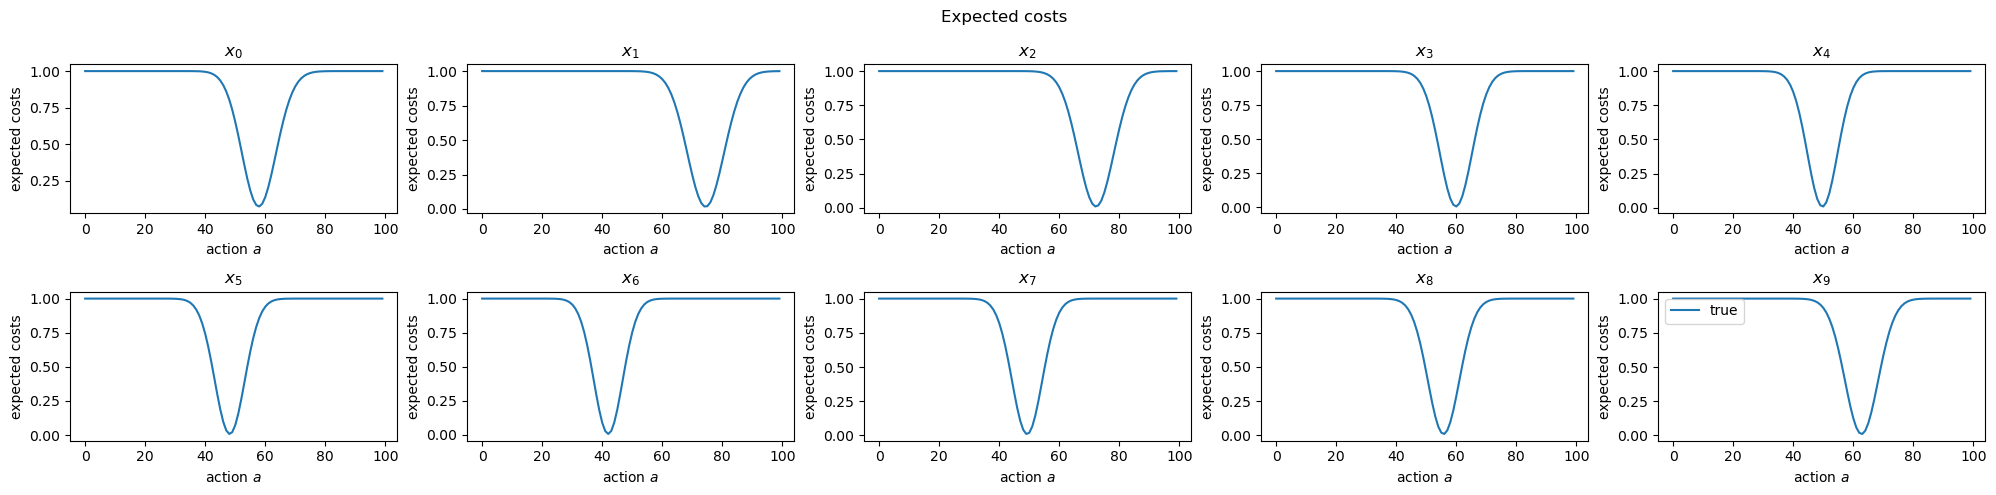

In [13]:
a_grid = torch.arange(sir.action_low, sir.action_high, 1.0)
expected_costs_post = []

plt.figure(figsize=(20, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = torch.tensor(
        [sir.expected_posterior_costs(x=i + 1, a=a, param=None, cost_fn=cost_fn) for a in a_grid]
    )
    expected_costs_post.append(expected_posterior_costs)

    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
plt.show()

### Load data

In [14]:
n_train = 10_000
n_test = 5_000

(
    theta_train,
    x_train,
    theta_val,
    x_val,
    theta_test,
    x_test,
) = load_data(task_name=task_name)


x_train = x_train[:n_train]
x_val = x_val[:n_test]
x_test = x_test[:n_test]
theta_train = sir.param_aggregation(theta_train[:n_train])
theta_val = sir.param_aggregation(theta_val[:n_test])
theta_test = sir.param_aggregation(theta_test[:n_test])


Load data from './data/sir', device = cpu.


Inspect the data

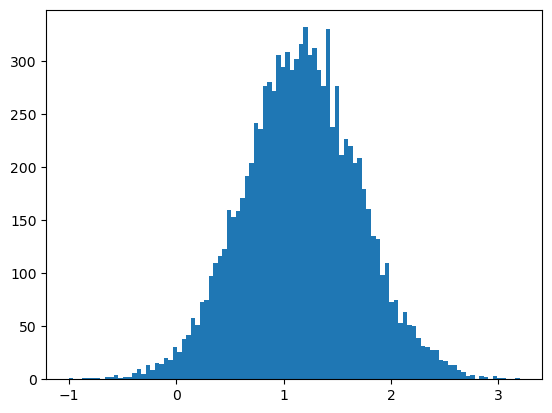

In [15]:
#plt.hist(costs_train.numpy(), bins=100)
plt.hist(theta_train.numpy(), bins=100)
plt.show()

In [16]:
print(f"N_train = {x_train.shape[0]}, N_val = {x_val.shape[0]}, N_test = {x_test.shape[0]}")

N_train = 10000, N_val = 5000, N_test = 5000


### Train a neural network to predict expected costs

In [17]:
nn = build_nn(
    "fc",
    x_train=x_train,
    action_train=sir.actions.sample(theta_train.shape[0]),
    hidden_dims=[100, 100, 100],
    output_dim=1,
    activation=torch.nn.ReLU(),
    output_transform=torch.nn.Sigmoid(),
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn,
    x_val=x_val,
    theta_val=theta_val,
    actions=sir.actions,
    learning_rate=1e-3,
    model_dir="./results/sir/continuous/notebook",
    # max_num_epochs=800,
    stop_after_epochs=50,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=11, out_features=100, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=100, out_features=100, bias=True)
  )
  (final_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Sigmoid()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 292 epochs. train_loss = 0.00610067	 last_improvement = 28


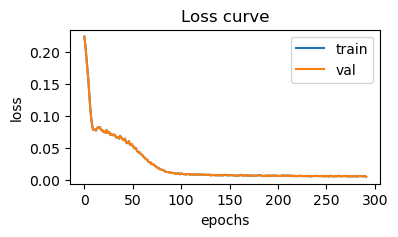

In [18]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss[0:], label="train")
ax.plot(train_loss[0:], label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate model

In [19]:
x_reference = torch.vstack([sir.get_observation(i) for i in range(1,11)])
post_reference = torch.stack([sir.get_reference_samples(i) for i in range(1,11)])[:,:,param]
param_reference = torch.vstack([sir.get_true_parameters(i) for i in range(1,11)])[:,param]

Check predictions on the reference observations

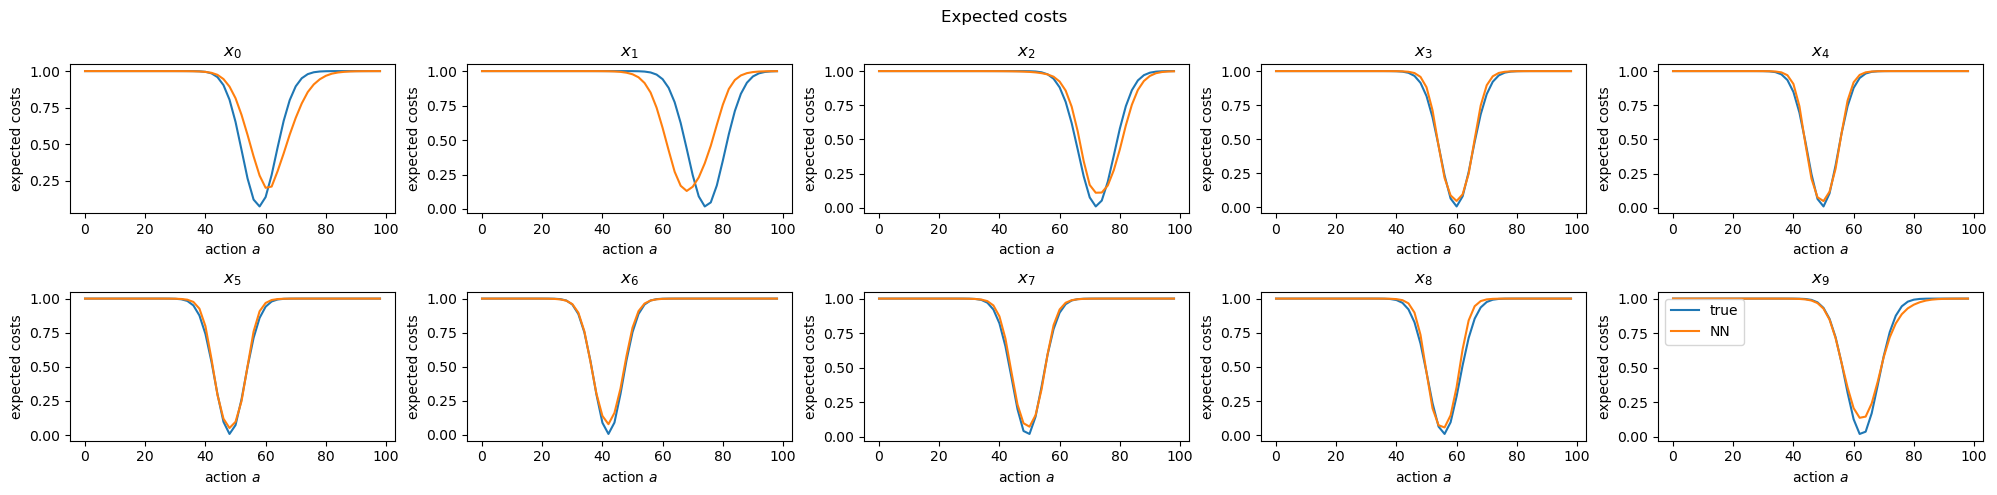

In [22]:
a_grid = torch.arange(sir.action_low, sir.action_high, 2.0)
expected_costs_post = []
expected_costs_nn = []

plt.figure(figsize=(20, 5))
for i, x in enumerate(x_reference):
    plt.subplot(2, 5, i + 1 % 5)

    expected_posterior_costs = torch.tensor(
        [sir.expected_posterior_costs(x=i + 1, a=a, param=None, cost_fn=cost_fn) for a in a_grid]
    )
    predicted_costs = torch.tensor([nn(x.unsqueeze(0), a).detach() for a in a_grid])
    expected_costs_post.append(expected_posterior_costs)
    expected_costs_nn.append(predicted_costs)

    plt.plot(a_grid, expected_posterior_costs, label="true")
    plt.plot(a_grid, predicted_costs, label="NN")
    plt.xlabel(r"action $a$")
    plt.ylabel("expected costs")
    plt.title(rf"$x_{i}$")
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
# plt.savefig("./results/continuous/toy_example/fig_expected_costs.pdf")
plt.show()

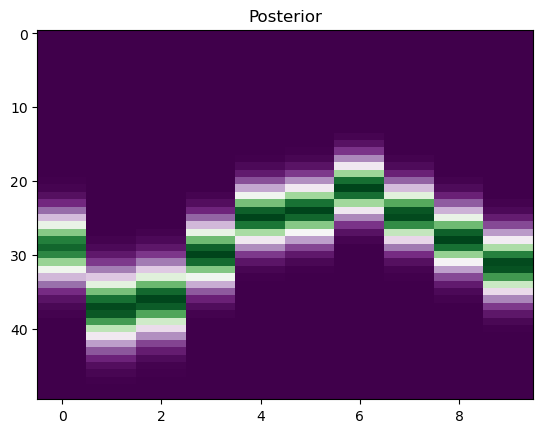

In [23]:
plt.title("Posterior")
plt.imshow(torch.stack(expected_costs_post).T, aspect="auto", cmap="PRGn_r")
plt.show()

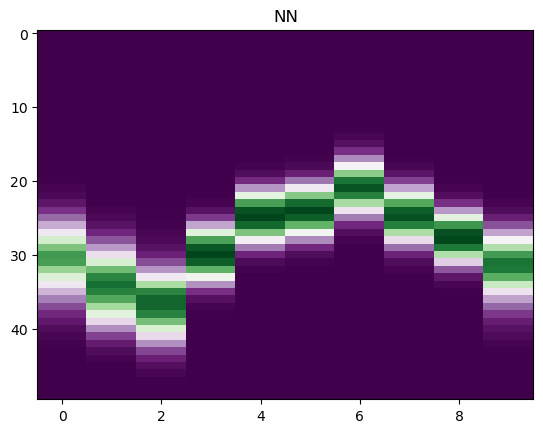

In [24]:
plt.title("NN")
plt.imshow(torch.stack(expected_costs_nn).T, aspect="auto", cmap="PRGn_r")
plt.show()